In [9]:
#Data preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler

#Data preprocessing
data = pd.read_csv('LoanStats3b.csv',skiprows=1,low_memory=False)
data = data.drop([data.index[len(data)-1], data.index[len(data)-2]])
c = []
#Dropping columns filled with more than half null values
data = data.dropna(thresh = len(data)*9/10,axis=1)
#Removing redundant and irrelevant columns
#Removing columns which have same values throughout
del_col = ['funded_amnt_inv','emp_title','pymnt_plan','title','zip_code','out_prncp','out_prncp_inv','funded_amnt','total_pymnt_inv','policy_code','application_type','delinq_amnt','hardship_flag','debt_settlement_flag','earliest_cr_line','last_pymnt_d','last_credit_pull_d','revol_util']
data = data.drop(labels = del_col,axis=1)

#Removing percentage from rate
#Selecting month from date and no of months from term
data.iloc[:,2] = data.iloc[:,2].apply(lambda x: float(x[:-1]))
data.iloc[:,1] = data.iloc[:,1].apply(lambda x: float(x[:-7]))
data.iloc[:,10] = data.iloc[:,10].apply(lambda x:(x[:-5]))

#Converting employed length to numerical form
data["emp_length"] = data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
data["emp_length"] = data["emp_length"].apply(lambda x:float(x))
#Converting months to numerical form
month = {'Jan':1, 'Feb':2,'Mar':3, 'Apr':4, 'May':5, 'Jun':6,'Jul':7,'Aug':8,'Sep':9, 'Oct':10,'Nov':11, 'Dec':12}
data['issue_d'] = data['issue_d'].replace(month)
data['issue_d'] = data['issue_d'].apply(lambda x:int(x))
#Converting the output from labels to classes
data = data[(data['loan_status']=="Fully Paid") | (data['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
data= data.replace({"loan_status": di})
data = data[[c for c in data if c not in ['loan_status']] + ['loan_status']]
#Converting categorical data to numerical form
string_label = ['grade','sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status']
for i in string_label:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])

#Applying standardization
scl = StandardScaler()
fields = data.columns.values[:-1]
#Filling null values by mean
data.fillna(data.mean(),inplace = True)

data_clean = pd.DataFrame(scl.fit_transform(data[fields]), columns = fields)


data_clean['loan_status'] = data['loan_status']

data_clean['loan_status'].fillna(0, inplace=True)

data_clean.to_csv('loanCleaned.csv', index=False)
print(data.shape)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(188180, 44)


In [11]:
cor = data_clean.corr()
cor_target = abs(cor['loan_status'])
relevant_features = cor_target[cor_target>0.05]
print(cor_target)

loan_amnt                     0.002726
term                          0.003856
int_rate                      0.009593
installment                   0.002980
grade                         0.008820
sub_grade                     0.009378
emp_length                    0.007458
home_ownership                0.007472
annual_inc                    0.007404
verification_status           0.002522
issue_d                       0.002901
purpose                       0.004592
addr_state                    0.003691
dti                           0.000634
delinq_2yrs                   0.003434
inq_last_6mths                0.000611
open_acc                      0.002459
pub_rec                       0.000006
revol_bal                     0.007061
total_acc                     0.004920
initial_list_status           0.001424
total_pymnt                   0.017189
total_rec_prncp               0.024174
total_rec_int                 0.003466
total_rec_late_fee            0.002540
recoveries               

In [12]:
print(data_clean.describe())

          loan_amnt          term      int_rate   installment         grade  \
count  1.881800e+05  1.881800e+05  1.881800e+05  1.881800e+05  1.881800e+05   
mean  -5.678905e-17 -6.585113e-17 -5.678905e-16 -7.128838e-17  4.591455e-17   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -1.645663e+00 -5.547850e-01 -1.865596e+00 -1.808395e+00 -1.364211e+00   
25%   -7.830376e-01 -5.547850e-01 -7.072502e-01 -7.160736e-01 -5.876474e-01   
50%   -2.685431e-01 -5.547850e-01 -4.244092e-02 -1.876135e-01  1.889166e-01   
75%    6.957492e-01 -5.547850e-01  6.742010e-01  5.546128e-01  1.889166e-01   
max    2.544233e+00  1.802500e+00  2.655107e+00  3.974459e+00  3.295173e+00   

          sub_grade    emp_length  home_ownership    annual_inc  \
count  1.881800e+05  1.881800e+05    1.881800e+05  1.881800e+05   
mean   7.249665e-18  3.504005e-17   -6.041388e-17  1.365354e-16   
std    1.000003e+00  1.000003e+00    1.000003e+00  1.000003e+00   
min   -1.676095e+00 

Using TensorFlow backend.


Accuracies from cross validation  [84.86881435 84.46363334 84.13816008 84.15808701 84.64859838 83.88468181
 84.30981799 83.96439485 83.91789558 84.46924405]


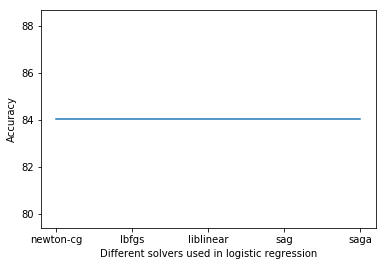

In [13]:
#Logistic regression using inbuilt class
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_wo_pca_scores = []
lg_wo_pca_fnr = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    lg_wo_pca_scores.append(accuracy_score(y_test, y_pred)*100)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred)
    log_wo_pca_fnr.append(fn/len(y_test))
print("Accuracies from cross validation ",np.array(lg_wo_pca_scores))
print("False negative rates from cross validation", np.array(lg_wo_pca_fnr))
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scores_solvers = []
fnr_solvers = []
for s in solvers:
        model = LogisticRegression(solver=s).fit(X_train_test, y_train_test)
        y_pred = model.predict(X_validation)
        scores_solvers.append(accuracy_score(y_validation, y_pred)*100)
        tn, fp, fn, tp = confusion_matrix(y_validation, y_pred)
        fnr_solvers.append(fn/len(y_validation))
plt.plot(solvers, scores_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('Accuracy')
plt.show()

plt.plot(solvers, fnr_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('False Negative Rate')
plt.show()

In [2]:
#Implementation of logistic regression
import math
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from numpy import vstack
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_m_wo_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)

def sigmoid(z):
    temp = 1 + (np.exp(-z))
    return 1/temp
def hypothesis(theta, x):
    
    if(sigmoid(np.dot(theta,x))<0.5):
        return 0
    else:
        return 1
def gradient(x,theta,y):
    h = []
    for i in x:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    error = np.dot(x.T, (h-y))/y.shape[0]
    return np.array(error)
def gradient_descent(X,y,theta, alpha=0.1):
    num_iter = 250
    for i in tqdm(range(num_iter)):
        e = gradient(X,theta,y)
        theta = theta - alpha * e
    return theta, num_iter
def predict(theta, X):
    h = []
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    for i in X:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    return h
def logistic_reg(X, y, X_test):
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    theta = np.ones(X.shape[1])
    theta, num_iter = gradient_descent(X,y,theta)
    y_pred = predict(theta,X_test)
    return theta,y_pred
a_scores = []
alphas = [0.1,0.001, 0.0001, 0.5,0.05,0.005, 1]
for alpha in alphas:
    theta, y_pred = logistic_reg(X_train_test,y_train_test, X_validation)
    

kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    theta, y_pred = logistic_reg(X_train, y_train, X_test)
    lg_m_wo_pca_scores.append(accuracy_score(y_test, y_pred))
print(np.array(lg_m_wo_pca_scores)*100)

100%|██████████| 250/250 [04:46<00:00,  1.08s/it]

[77.59548323 77.81467951 77.94088343 77.79475257 77.81320579 77.6006377
 77.9527036  77.2352863  78.64354989 77.06257473]


In [15]:
#ANN implementation

import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.utils import to_categorical

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
ANN_wo_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    model = keras.Sequential([
        keras.layers.Dense(43, input_shape=(43,),activation='relu'),
        keras.layers.Dense(23, activation='relu'),
        keras.layers.Dense(2,activation='softmax')
        ])
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, batch_size=10000, verbose=0)
    y_pred = model.predict(X_test)
    score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))*100
    print(score)
    ANN_wo_pca_scores.append(score)
print("Accuracies from ANN",np.array(ANN_wo_pca_scores))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
84.21786781800067
84.07837927598804
84.08502158751246
84.16472932580538
84.24339046100704
83.93782383419689
84.60874186262787
84.37624551614189
84.19024843895309
84.22346220273681
Accuracies from ANN [84.21786782 84.07837928 84.08502159 84.16472933 84.24339046 83.93782383
 84.60874186 84.37624552 84.19024844 84.2234622 ]


In [16]:
from sklearn.svm import LinearSVC
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
linear_svc_wo_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    linear_svc_wo_pca_scores.append(accuracy_score(y_test, y_pred))

0.839853869146463
0.8381932912653604
0.8419794088342744
0.8434407173696447
0.8390461007041318
0.8446260130197955
0.8436960276338514
0.8387139630662946
0.8473495416500598
0.8451574332403348


In [17]:
#ANN using PCA
from sklearn.decomposition import PCA
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
ANN_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_pca,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    model = keras.Sequential([
        keras.layers.Dense(15, input_shape=(15,),activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(2,activation='softmax')
        ])
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, batch_size=10000, verbose=0)
    y_pred = model.predict(X_test)
    score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))*100
    print(score)
    ANN_pca_scores.append(score)
print(np.array(ANN_pca_scores).mean())

84.33742942544006
84.28429093324476
84.1846562603786
83.90567917635337
84.16367742792613
84.26331871927727
84.15039192241265
84.43603029095257
84.30317523581772
83.88468181214294
84.1913331203946


In [18]:
#Linear svm with PCA
from sklearn.svm import LinearSVC
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
linear_svc_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
ANN_pca_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_pca,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    linear_svc_pca_scores.append(accuracy_score(y_test, y_pred))

0.84304217867818
0.8439721022915975
0.8438392560611092
0.8441049485220857
0.8395775209246712
0.8438288826889864
0.8418360568619636
0.8373854125149462
0.8444267304370932
0.8434967450511492


In [5]:
#Implementation of logistic regression with PCA
import math
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from numpy import vstack
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_m_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_pca,y, test_size=0.2)

def sigmoid(z):
    temp = 1 + (np.exp(-z))
    return 1/temp
def hypothesis(theta, x):
    
    if(sigmoid(np.dot(theta,x))<0.5):
        return 0
    else:
        return 1
def gradient(x,theta,y):
    h = []
    for i in x:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    error = np.dot(x.T, (h-y))/y.shape[0]
    return np.array(error)
def gradient_descent(X,y,theta):
    alpha = 0.1
    num_iter = 150
    for i in tqdm(range(num_iter)):
        e = gradient(X,theta,y)
        theta = theta - alpha * e
    return theta, num_iter
def predict(theta, X):
    h = []
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    for i in X:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    return h
def logistic_reg(X, y, X_test):
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    theta = np.ones(X.shape[1])
    theta, num_iter = gradient_descent(X,y,theta)
    y_pred = predict(theta,X_test)
    return theta,y_pred


kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    theta, y_pred = logistic_reg(X_train, y_train, X_test)
    lg_m_pca_scores.append(accuracy_score(y_test, y_pred))
print(np.array(lg_m_pca_scores)*100)

100%|██████████| 150/150 [02:38<00:00,  1.00it/s]

[81.54101627 81.36831617 81.36831617 81.76021255 81.02829813 81.82542846
 81.26079447 81.48664807 81.67264514 81.96492627]


Accuracies from cross validation  [84.70939887 83.79275988 84.53669877 84.02524078 84.05075063 84.11053541
 84.49581507 83.64554271 84.13046366 84.27660422]


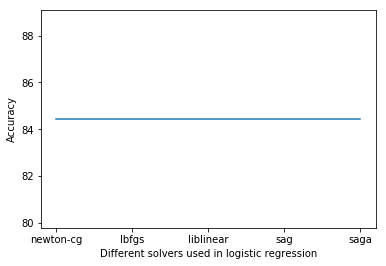

In [20]:
#Logistic regression using inbuilt class with PCA
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_pca,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    lg_pca_scores.append(accuracy_score(y_test, y_pred)*100)
print("Accuracies from cross validation ",np.array(lg_pca_scores))

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scores_solvers = []
for s in solvers:
        model = LogisticRegression(solver=s).fit(X_train_test, y_train_test)
        y_pred = model.predict(X_validation)
        scores_solvers.append(accuracy_score(y_validation, y_pred)*100)

plt.plot(solvers, scores_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('Accuracy')
plt.show()



In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

def convert(y):
    a =[]
    for i in y:
        a.append(1-i)
    return np.array(a)    

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
kmeans_scores = []
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X,y, test_size=0.2)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X_train_test[train_index], X_train_test[test_index]
    y_train, y_test = y_train_test[train_index], y_train_test[test_index]
    s = X[0]
    kmeans = KMeans(n_clusters=2, precompute_distances='auto').fit(X_train)
    pred = kmeans.predict(s.reshape(1,43))
    y_pred = kmeans.predict(X_test)
    if(pred==0):
        score = accuracy_score(y_test, y_pred)
        kmeans_scores.append(score*100)
    else:
        temp = convert(y_test)
        score = accuracy_score(temp, y_pred)
        kmeans_scores.append(score*100)
print(kmeans_scores)


[60.106276984390576, 60.77715044835603, 61.14911989372301, 60.54466954500166, 60.54204862495018, 61.113325362030025, 59.93755812408662, 60.91404277932775, 61.29932243921882, 60.83432974624684]
